## Data Extraction For News Classification

The data for this task was gotten from [arisetv](https://www.arise.tv/), where news are grouped into different categories. The goal here to extract the news title and excerpt from news articles for different categories

In [1]:
# import the required dependencies
import requests
from bs4 import BeautifulSoup
import pandas as pd
import json
import urllib.request,sys,time

In [2]:
%%time
columns = ['Title', 'Excerpt', 'Category'] 
df = pd.DataFrame(columns = columns)  # initialize an empty dataframe with column names
base_url = 'https://www.arise.tv/'

categories =  ['health','business', 'politics', 'entertainment', 'sports', 'tech']  # news categories we are interested in

'''Search through each news based category in arisetv website and for each news article, extract the title and excerpt and append it to the dataframe'''
for cat in categories:
  for page_number in range(1, 170):
    url = base_url + cat + '/'  if page_number == 1 else base_url + cat + '/' + 'page/'+str(page_number) + '/'
    try:
      page=requests.get(url) 
    except Exception as e:    
      error_type, error_obj, error_info = sys.exc_info()      
      print ('ERROR FOR LINK:',url)               
      print (error_type, 'Line:', error_info.tb_lineno)
      continue
    if page.status_code == 200:
      soup = BeautifulSoup(page.text, "html.parser")
      articles = soup.find_all('article',attrs={'class':'jeg_post jeg_pl_lg_2 format-standard'})
      for article in articles:
        title = article.find('h3',attrs={'class':'jeg_post_title'}).get_text()
        excerpt = article.find('div',attrs={'class':'jeg_post_excerpt'}).get_text()
        df = df.append({'Title' : title, 'Excerpt' : excerpt, 'Category' : cat},
                ignore_index = True)

    # check progress 
    if page_number % 50 == 0:
        print(cat, page_number)

health 50
health 100
health 150
business 50
business 100
business 150
politics 50
politics 100
politics 150
entertainment 50
entertainment 100
entertainment 150
sports 50
sports 100
sports 150
tech 50
tech 100
tech 150
CPU times: user 1min 33s, sys: 3.07 s, total: 1min 36s
Wall time: 1h 25min 26s


In [3]:
df.head()

,Title,Excerpt,Category
0,"\nBiden Tests Positive for Covid Again, Return...","\nWhite House physician, Kevin O'Connor, said ...",health
1,"\nBiden’s Health Improving, No Close Contacts ...",\nThe White House has sought to underscore Bid...,health
2,\nWHO Declares Monkeypox Global Health Emergen...,"\nThe WHO label - a ""public health emergency o...",health
3,"\nBiden Tests Positive for Covid, Has Mild Sym...",\nUS President Joe Biden has tested positive f...,health
4,\nGhana Declares First-Ever Outbreak of Marbur...,\nMarburg is a highly infectious viral haemorr...,health


### Data Cleaning.

Now lets clean the data a little bit by removing '/n' and '... Read more'

In [4]:
df.head(2)

,Title,Excerpt,Category
0,"\nBiden Tests Positive for Covid Again, Return...","\nWhite House physician, Kevin O'Connor, said ...",health
1,"\nBiden’s Health Improving, No Close Contacts ...",\nThe White House has sought to underscore Bid...,health


In [5]:
def clean_text(text):

  '''
      function takes in a text and returns a clean version with both new line characters and readmore prompt removed

      input: str
      return : str
  '''
  text = text.replace('...\nRead more\n', '', -1)
  text = text.replace('\n', '')
  text = text.strip()
  return text

In [6]:
data = df.copy()  # create a copy of the data
# clean data
data['Title'] = data['Title'].map(lambda x : clean_text(x))
data['Excerpt'] = data['Excerpt'].map(lambda x : clean_text(x)) 

In [7]:
data.head()

,Title,Excerpt,Category
0,"Biden Tests Positive for Covid Again, Returns ...","White House physician, Kevin O'Connor, said Bi...",health
1,"Biden’s Health Improving, No Close Contacts Te...",The White House has sought to underscore Biden...,health
2,WHO Declares Monkeypox Global Health Emergency...,"The WHO label - a ""public health emergency of ...",health
3,"Biden Tests Positive for Covid, Has Mild Symptoms",US President Joe Biden has tested positive for...,health
4,Ghana Declares First-Ever Outbreak of Marburg ...,Marburg is a highly infectious viral haemorrha...,health


### Prepare Data

* Create json file that maps categories to indexx
* shuffle the data based on the category
* split the data to train and test sets

In [8]:
cat_mapping = {k:v for v,k in enumerate(categories)}
json.dumps(cat_mapping, indent = 2)

'{\n  "health": 0,\n  "business": 1,\n  "politics": 2,\n  "entertainment": 3,\n  "sports": 4,\n  "tech": 5\n}'

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split

In [10]:
data = data.sample(frac = 1, random_state= 42)
train, test = train_test_split(data, test_size = 0.15, shuffle = True, stratify= data['Category'], random_state = 42)
train.reset_index()
test.reset_index()
train.head()

,Title,Excerpt,Category
4420,"Uefa Opens Proceedings against Barcelona, Juve...",Uefa has opened disciplinary proceedings again...,sports
698,Amazon Blames Inflation as It Increases Cost o...,The increases are steeper than the 17 percent ...,business
2606,Nigeria’s Parliament Passes Amended Electoral ...,Nigeria's Senate on Tuesday passed the harmoni...,politics
527,Nigeria: Lagos Governor Tests Positive for Cov...,"The Lagos State Governor, Mr. Babajide Sanwo-O...",health
2950,South Africa Calls For Calm as Electoral Refor...,South Africa has raised concerns about the det...,politics


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

#### See distribution of target variable to verify our split

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


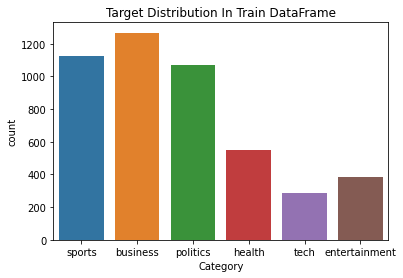

In [12]:
sns.countplot('Category', data = train)
plt.title('Target Distribution In Train DataFrame')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


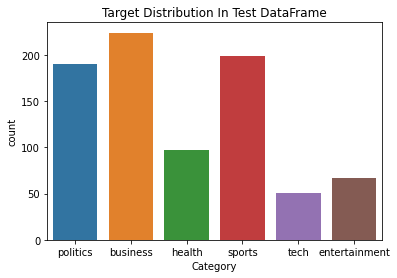

In [13]:
sns.countplot('Category', data = test)
plt.title('Target Distribution In Test DataFrame')
plt.show()

### Saving files

In [14]:
train.to_csv('train.csv',index=False)
test.to_csv('test.csv',index=False)

with open('cat_mapping.json', 'w') as fp:
    json.dump(cat_mapping, indent=2, fp=fp)